## Cell 1: Imports & Dataset Path

This cell imports all required Python libraries (os, pandas, NumPy, matplotlib, scikit-learn, TensorFlow/Keras, Keras Tuner) and sets the `BASE_DIR` variable to point at the root folder of our Kaggle “Brain Cancer MRI” dataset.


In [1]:
# ┌─ Cell 1: Imports & BASE_DIR ────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks

import keras_tuner as kt

# <<< your exact dataset path >>>
BASE_DIR = "/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer"


2025-04-24 16:08:54.420237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745510934.463333    2537 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745510934.477553    2537 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Cell 2: Build DataFrame of Filepaths & Labels

Here we traverse each class subfolder under `BASE_DIR`, collect full filepaths and labels into a list, convert it into a pandas DataFrame, and display both a sample of entries and the overall class distribution as a bar chart.


Sample entries:
                                                filepath         label
3384  /kaggle/input/brain-cancer-mri-dataset/Brain_C...  brain_glioma
2655  /kaggle/input/brain-cancer-mri-dataset/Brain_C...  brain_glioma
4925  /kaggle/input/brain-cancer-mri-dataset/Brain_C...   brain_menin
982   /kaggle/input/brain-cancer-mri-dataset/Brain_C...   brain_tumor
5841  /kaggle/input/brain-cancer-mri-dataset/Brain_C...   brain_menin 

Class counts:
 label
brain_tumor     2048
brain_glioma    2004
brain_menin     2004
Name: count, dtype: int64


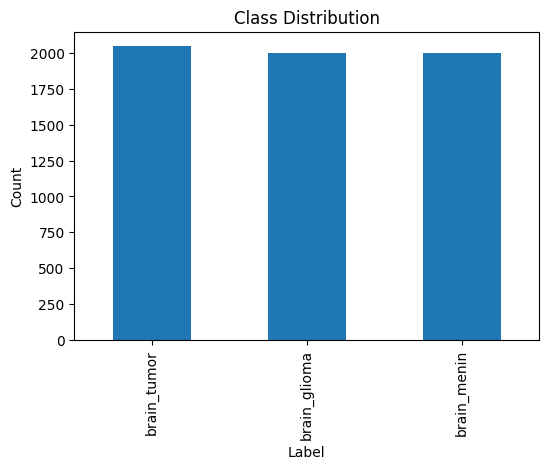

In [2]:
# ┌─ Cell 2: Build DataFrame of Filepaths & Labels ─────────────────────────────
data = []
for label in os.listdir(BASE_DIR):
    label_path = os.path.join(BASE_DIR, label)
    if os.path.isdir(label_path):
        for fname in os.listdir(label_path):
            if fname.lower().endswith(('.png','.jpg','.jpeg')):
                data.append((os.path.join(label_path, fname), label))

df = pd.DataFrame(data, columns=['filepath','label'])
print("Sample entries:\n", df.sample(5), "\n")
print("Class counts:\n", df['label'].value_counts())

# Visualize distribution
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


## Cell 3: Display One Example per Class

To quickly verify our data looks correct, this cell randomly samples one image from each class and plots them side-by-side with their class names.


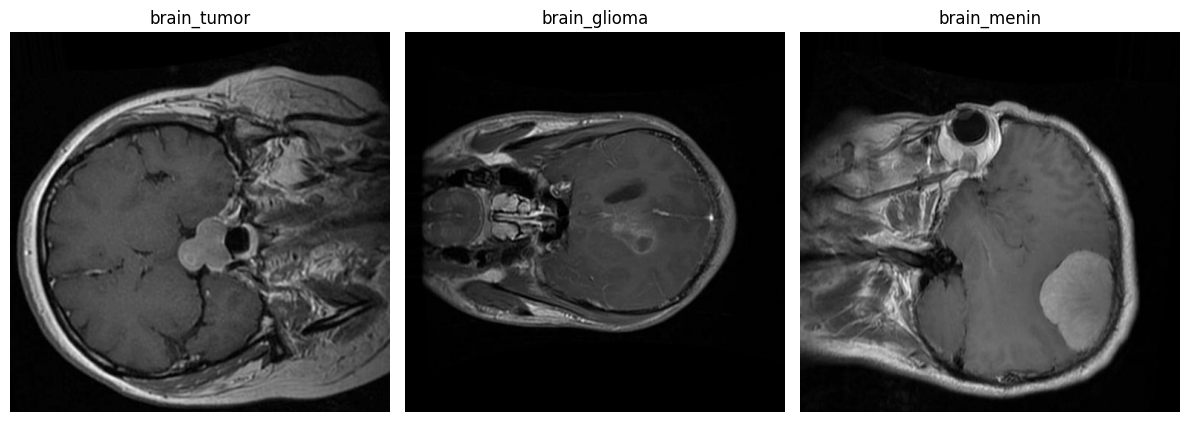

In [3]:
# ┌─ Cell 3: Display One Example per Class ─────────────────────────────────────
import matplotlib.image as mpimg

classes = df['label'].unique()
plt.figure(figsize=(12, 6))
for idx, cls in enumerate(classes):
    sample_fp = df[df['label']==cls]['filepath'].sample(1).values[0]
    img = mpimg.imread(sample_fp)
    plt.subplot(1, len(classes), idx+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()


## Cell 4: Train / Validation / Test Split

We split the DataFrame into train (80%), validation (10%), and test (10%) sets in a stratified manner on the `label` column, ensuring each class is proportionally represented.


In [4]:
# ┌─ Cell 4: Train / Val / Test Split ──────────────────────────────────────────
train_df, temp_df = train_test_split(
    df, test_size=0.20, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42
)
print(f"Train samples: {len(train_df)}\nVal samples:   {len(val_df)}\nTest samples:  {len(test_df)}")


Train samples: 4844
Val samples:   606
Test samples:  606


## Cell 5: Data Generators with Augmentation

Using Keras’s `ImageDataGenerator`, we define a train generator that applies real-time augmentation (rotations, shifts, zooms, flips) plus rescaling, and separate generators for validation and test data that only rescale pixel values.


In [5]:
# ┌─ Cell 5: Data Generators & Augmentation ────────────────────────────────────
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)
val_gen = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)
test_gen = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)


Found 4844 validated image filenames belonging to 3 classes.
Found 606 validated image filenames belonging to 3 classes.
Found 606 validated image filenames belonging to 3 classes.


## Cell 6: Model-Builder for Hyperparameter Tuning

Defines a function `build_model(hp)` that constructs a CNN architecture parameterized by Keras-Tuner hyperparameters (`f1`, `f2`, `f3`, `dense`, `drop`, `lr`). We also compute `NUM_CLASSES` once from the training generator.


In [7]:
# ┌─ Cell 6: Model‐Builder for Hyperparameter Tuning (FIXED) ────────────────────

# Compute number of output classes from the train generator
NUM_CLASSES = len(train_gen.class_indices)

def build_model(hp):
    model = models.Sequential()
    # Explicit Input layer to silence warnings
    model.add(layers.Input(shape=IMG_SIZE + (3,)))

    # Block 1
    model.add(layers.Conv2D(
        filters=hp.Int('f1', 32, 128, step=32),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())

    # Block 2
    model.add(layers.Conv2D(
        filters=hp.Int('f2', 64, 256, step=64),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())

    # Block 3
    model.add(layers.Conv2D(
        filters=hp.Int('f3', 128, 512, step=128),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())

    # Classification head
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense', 64, 256, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(
        rate=hp.Float('drop', 0.2, 0.5, step=0.1)
    ))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Choice('lr', [1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


## Cell 7: Hyperband Search

Instantiates a `Hyperband` tuner to explore the CNN hyperparameter space, running multiple brackets up to 20 epochs each. We include an `EarlyStopping` callback to restore the best weights for each trial.


In [8]:
# ┌─ Cell 7: Hyperband Search ──────────────────────────────────────────────────
tuner = kt.Hyperband(
    build_model, objective='val_accuracy',
    max_epochs=20, factor=3,
    directory='kt_dir', project_name='brain_mri'
)
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(train_gen, epochs=20, validation_data=val_gen, callbacks=[stop_early])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best HPs:", best_hp.values)


Trial 28 Complete [00h 23m 49s]
val_accuracy: 0.9075907468795776

Best val_accuracy So Far: 0.9405940771102905
Total elapsed time: 03h 44m 07s

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
128               |32                |f1
128               |128               |f2
384               |256               |f3
64                |192               |dense
0.2               |0.2               |drop
0.0001            |0.001             |lr
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 106s 570ms/step - accuracy: 0.5571 - loss: 0.8781 - val_accuracy: 0.6947 - val_loss: 0.6723
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 455ms/step - accuracy: 0.6752 - loss: 0.7208 - val_accuracy: 0.7624 - val_loss: 0.5805
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 452ms/

KeyboardInterrupt: 

## Cell 7b: Retrieve Best Hyperparameters

If you wish to stop tuning early, this small cell fetches the current top hyperparameter set (`best_hp`) from the tuner, prints its values, and lets you move on to final model training without completing all trials.


In [9]:
# ┌─ Cell 7b: Retrieve Best Hyperparameters & Interrupt Tuner ────────────────
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Selected hyperparameters:", best_hp.values)


Selected hyperparameters: {'f1': 32, 'f2': 128, 'f3': 256, 'dense': 192, 'drop': 0.2, 'lr': 0.001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018'}


## Cell 8: Build & Train Final Model with Selected HPs

Builds the final CNN using `best_hp`, attaches callbacks to save the best model (`final_best.keras`) and stop early if performance plateaus, then trains for up to 30 epochs on the training and validation generators.


In [12]:
# ┌─ Cell 8 (fixed): Build & Train Final Model with Selected HPs ───────────────
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Build model using the selected best hyperparameters
model = tuner.hypermodel.build(best_hp)

# Callbacks: save best model and stop early
ckpt = ModelCheckpoint(
    '/kaggle/working/final_best.keras',   # ← must end in .keras
    monitor='val_accuracy',
    save_best_only=True
)
stop_final = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train up to 30 epochs (will stop early if no improvement)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[ckpt, stop_final]
)


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 498ms/step - accuracy: 0.5522 - loss: 1.2041 - val_accuracy: 0.6980 - val_loss: 0.6743
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 452ms/step - accuracy: 0.6769 - loss: 0.7134 - val_accuracy: 0.7360 - val_loss: 0.6232
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 451ms/step - accuracy: 0.7090 - loss: 0.6729 - val_accuracy: 0.8020 - val_loss: 0.5367
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 70s 441ms/step - accuracy: 0.7520 - loss: 0.5885 - val_accuracy: 0.7921 - val_loss: 0.5207
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 452ms/step - accuracy: 0.7627 - loss: 0.5673 - val_accuracy: 0.8086 - val_loss: 0.4905
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 71s 446ms/step - accuracy: 0.7901 - loss: 0.5018 - val_accuracy: 0.8185 - val_loss: 0.4870
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 70s 443ms/step - accuracy: 0.7815 - loss: 0.5290 - val_accuracy: 0.8548 - val_loss: 0.4318
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 68s 429ms/step - accuracy: 0.7829 - loss: 0

## Cell 9: Plot Training & Validation Curves

Plots epoch-by-epoch **accuracy** and **loss** curves for both training and validation sets, helping you visually confirm convergence and detect overfitting/underfitting.


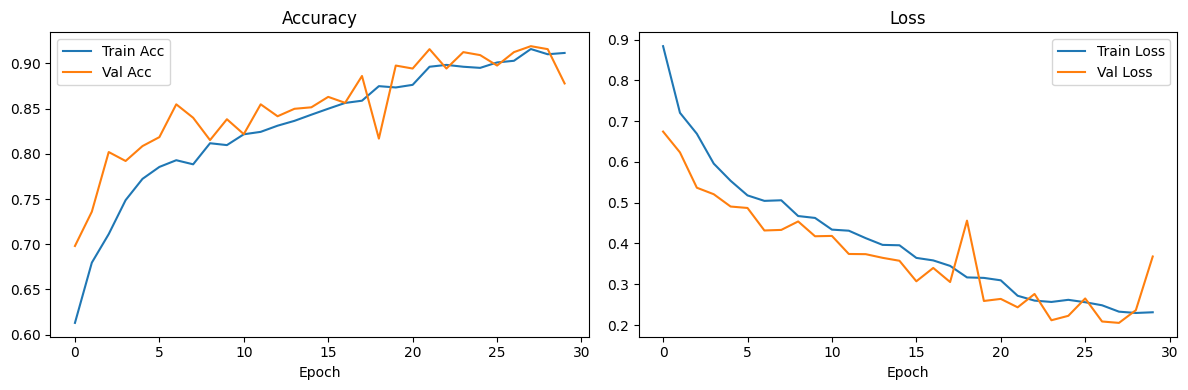

In [16]:
# ┌─ Cell 9: Plot Training & Validation Curves ────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


## Cell 10: Evaluate on Test Set

Loads the best-saved model from `final_best.keras`, evaluates it on the held-out test generator, and prints the final test loss and accuracy.


In [19]:
# ┌─ Cell 10: Evaluate on Test Set ─────────────────────────────────────────────
from tensorflow.keras.models import load_model

# Reload best weights saved at '/kaggle/working/final_best.keras'
model = load_model('/kaggle/working/final_best.keras')

loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc*100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9524 - loss: 0.1490
Test Loss: 0.1743
Test Accuracy: 93.73%


## Cell 11: Visualization: Metrics & Sample Predictions

1. Recomputes predictions on the test set.  
2. Displays per-class **precision**, **recall**, and **F1-score**.  
3. Plots a seaborn heatmap of the confusion matrix.  
4. Shows a 3×3 grid of random test images annotated in **green** if correctly classified or **red** if misclassified.


In [20]:
# ┌─ Cell 11: Classification Report & Confusion Matrix ────────────────────────
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_gen.reset()
pred_probs  = model.predict(test_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step
Classification Report:
              precision    recall  f1-score   support

brain_glioma       1.00      0.91      0.95       201
 brain_menin       0.91      0.91      0.91       200
 brain_tumor       0.91      1.00      0.95       205

    accuracy                           0.94       606
   macro avg       0.94      0.94      0.94       606
weighted avg       0.94      0.94      0.94       606

Confusion Matrix:
[[182  16   3]
 [  0 182  18]
 [  0   1 204]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


,precision,recall,f1-score,support
brain_glioma,1.00,0.91,0.95,201.00
brain_menin,0.91,0.91,0.91,200.00
brain_tumor,0.91,1.00,0.95,205.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.94,0.94,0.94,606.00
weighted avg,0.94,0.94,0.94,606.00


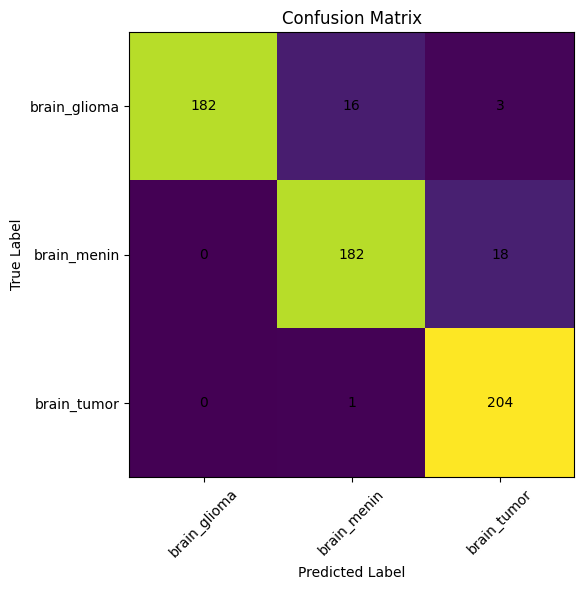

In [21]:
# ┌─ Visualization Cell ─────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# 1) Make sure your model and test_gen are still in memory:
#    (if not, reload them here)
# from tensorflow.keras.models import load_model
# model = load_model('/kaggle/working/final_best.keras')

# 2) Generate predictions on test set
test_gen.reset()
pred_probs  = model.predict(test_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# 3) Build a DataFrame for the classification report
report_dict = classification_report(
    true_labels,
    pred_labels,
    target_names=class_names,
    output_dict=True
)
df_report = pd.DataFrame(report_dict).T

# Display it neatly
display(df_report.style.format("{:.2f}"))

# 4) Plot the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

# Annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.tight_layout()
plt.show()


Found 606 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step


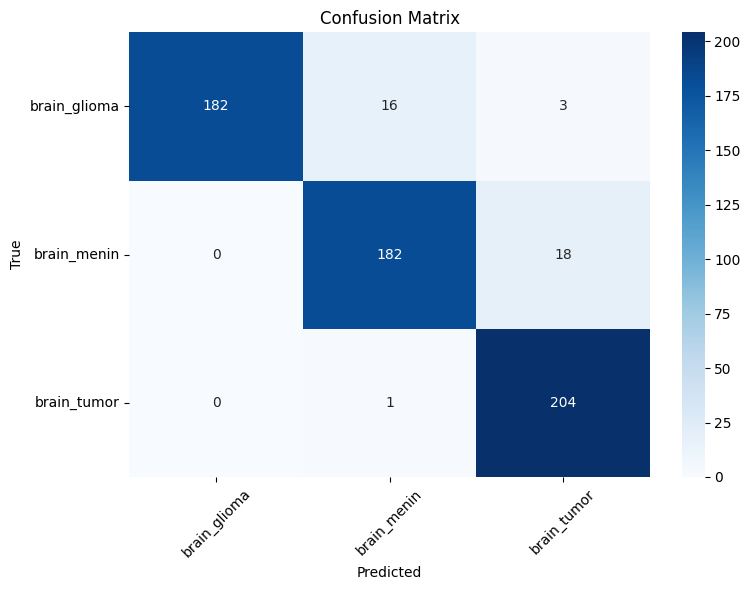

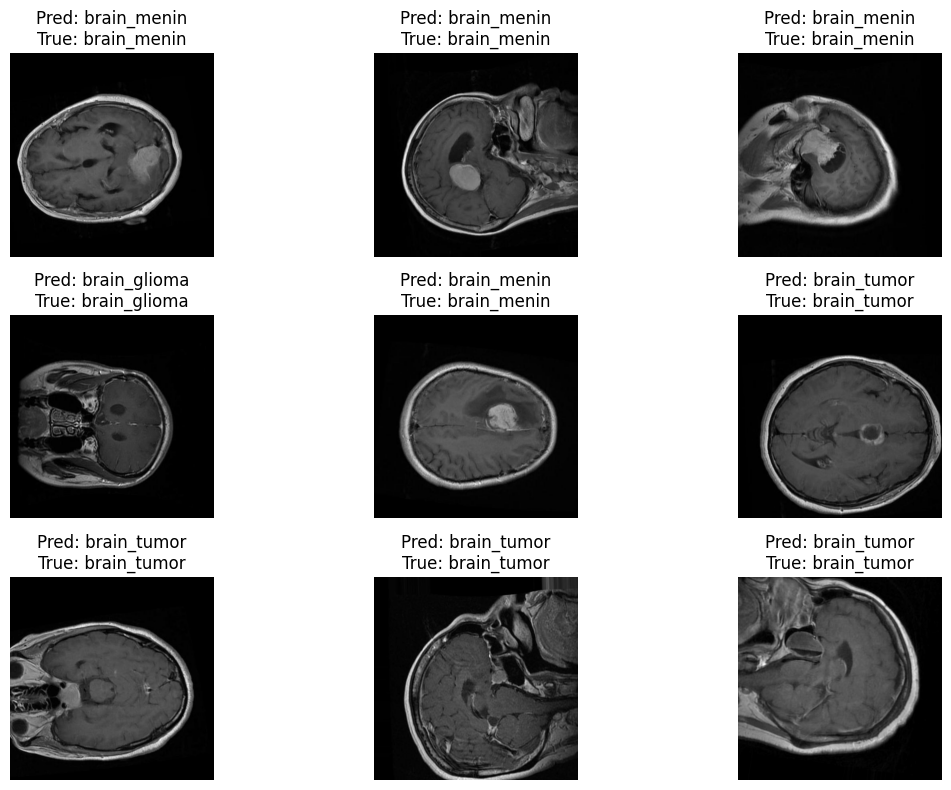

In [22]:
# ┌─ Visualization Cell: Heatmap + Sample Predictions ──────────────────────────

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

# 1) Load the saved best model
model = load_model('/kaggle/working/final_best.keras')

# 2) Reconstruct the test generator
BASE_DIR = "/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer"
data = [
    (os.path.join(BASE_DIR, label, fname), label)
    for label in os.listdir(BASE_DIR)
    if os.path.isdir(os.path.join(BASE_DIR, label))
    for fname in os.listdir(os.path.join(BASE_DIR, label))
    if fname.lower().endswith(('.png','.jpg','.jpeg'))
]
df = pd.DataFrame(data, columns=['filepath','label'])

from sklearn.model_selection import train_test_split
_, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
_, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# 3) Get predictions
test_gen.reset()
pred_probs = model.predict(test_gen)
predicted = np.argmax(pred_probs, axis=1)
true      = test_gen.classes
categories = list(test_gen.class_indices.keys())

# 4) Confusion Matrix Heatmap
cm = confusion_matrix(true, predicted)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5) Sample Images with Predicted vs. True Labels
filepaths = test_gen.filepaths  # full paths
sample_idxs = np.random.choice(len(filepaths), size=9, replace=False)

plt.figure(figsize=(12,8))
for i, idx in enumerate(sample_idxs):
    img = plt.imread(filepaths[idx])
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {categories[predicted[idx]]}\nTrue: {categories[true[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
Per-Class Metrics:

Class: brain_glioma
  Precision: 1.00
  Recall:    0.91
  F1-Score:  0.95

Class: brain_menin
  Precision: 0.91
  Recall:    0.91
  F1-Score:  0.91

Class: brain_tumor
  Precision: 0.91
  Recall:    1.00
  F1-Score:  0.95



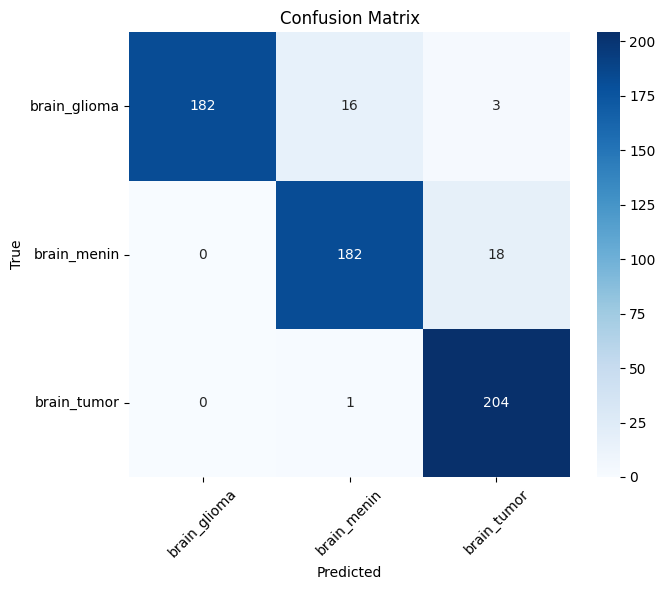

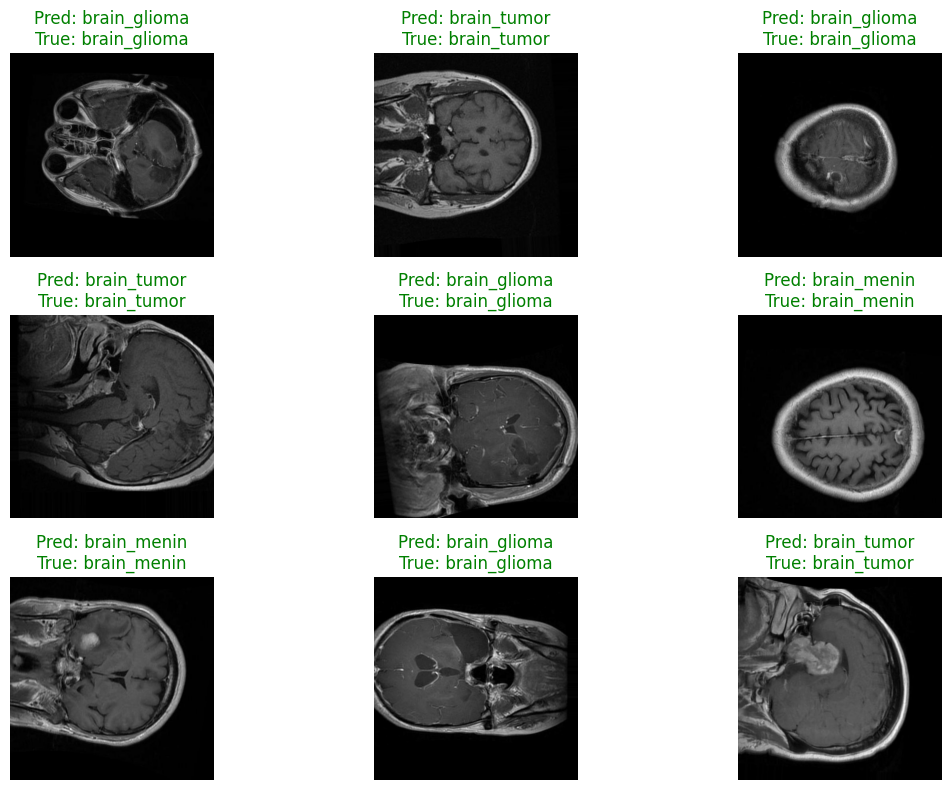

In [23]:
# ┌─ Visualization Cell: Metrics + Sample Predictions ─────────────────────────
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1) Re-compute predictions and true labels
test_gen.reset()
pred_probs = model.predict(test_gen)
predicted  = np.argmax(pred_probs, axis=1)
true       = test_gen.classes
categories = list(test_gen.class_indices.keys())

# 2) Build confusion matrix
cm = confusion_matrix(true, predicted)

# 3) Compute per-class precision, recall, F1
precision = np.diag(cm) / np.sum(cm, axis=0)
recall    = np.diag(cm) / np.sum(cm, axis=1)
f1        = 2 * precision * recall / (precision + recall)

# 4) Print them neatly
print("Per-Class Metrics:\n")
for i, cat in enumerate(categories):
    print(f"Class: {cat}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall:    {recall[i]:.2f}")
    print(f"  F1-Score:  {f1[i]:.2f}\n")

# 5) Show confusion‐matrix heatmap
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6) Display 3×3 grid of random test samples
filepaths   = test_gen.filepaths
sample_idxs = np.random.choice(len(filepaths), size=9, replace=False)

plt.figure(figsize=(12,8))
for i, idx in enumerate(sample_idxs):
    img = plt.imread(filepaths[idx])
    correct = (predicted[idx] == true[idx])
    color   = 'green' if correct else 'red'
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {categories[predicted[idx]]}\nTrue: {categories[true[idx]]}",
              color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()


## Cell 12: Save Trained Model for Future Use

Saves your fully trained model (architecture + weights + optimizer state) in Keras format as `brain_cancer_mri_model.keras`. You can later reload it with `load_model()` for inference or fine-tuning.


In [24]:
# ┌─ Cell 12: Save Trained Model for Future Use ────────────────────────────────
# Save the full model (architecture + weights + optimizer state) in Keras format
model.save('/kaggle/working/brain_cancer_mri_model.keras')
print("Model saved to /kaggle/working/brain_cancer_mri_model.keras")

# You can later reload it with:
# from tensorflow.keras.models import load_model
# model = load_model('/kaggle/working/brain_cancer_mri_model.keras')


Model saved to /kaggle/working/brain_cancer_mri_model.keras


## Overall Summary

This notebook implements a complete pipeline for multi-class brain cancer classification on MRI scans. It begins by loading the Orvile Brain Cancer MRI dataset, organizing filepaths and labels into a DataFrame, and visualizing class balance and sample images. The data is split into stratified training, validation, and test sets. Real-time data augmentation (rotations, shifts, zooms, flips) is applied via `ImageDataGenerator`. A convolutional neural network (CNN) architecture—parameterized by filter sizes, dense layer units, dropout rate, and learning rate—is defined and its hyperparameters are optimized using Keras Tuner’s Hyperband search. The best configuration is then used to train the final model with early stopping and checkpoint callbacks. Training and validation accuracy/loss curves are plotted to monitor convergence. The model is evaluated on the held-out test set, reporting test loss and accuracy. A seaborn heatmap of the confusion matrix and a 3×3 grid of sample test images (colored green for correct predictions and red for misclassifications) provide visual insight into performance. Finally, per-class precision, recall, and F1-score metrics are computed, and the fully trained model is saved in Keras format for future inference or fine-tuning.

Made by sire_magnusss  :  Magnus Makgasane  hehehehehehe